In [143]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

# Data Cleaning, Missing Data and Normalization

## Removing Non-Predictive Features & Potential Target Features

The non-predictive and potential target features listed on https://archive.ics.uci.edu/dataset/211/communities+and+crime+unnormalized are removed from the dataset.

In [144]:
# Load the data
df_unclean = pd.read_csv('CommViolPredUnnormalizedData.csv', na_values=['?'])

In [145]:
# Removing the non-predictive features
columns_to_remove = [
    'communityname',
    'state',
    'countyCode',
    'communityCode',
    'fold',
    'Unnamed: 0'
]

# Removing potential target features
columns_to_remove += [
        'murders', 
        'murdPerPop', 
        'rapes', 
        'rapesPerPop', 
        'robberies', 
        'robbbPerPop', 
        'assaults', 
        'burglaries',
        'burglPerPop', 
        'larcenies', 
        'larcPerPop',
        'autoTheft', 
        'autoTheftPerPop', 
        'arsons', 
        'arsonsPerPop',
        'ViolentCrimesPerPop', 
        'nonViolPerPop'
    ]


df_cleaned = df_unclean.drop(columns=columns_to_remove)

## Handling Features with Missing Data

First, the missing data in the dataset is identified. For each feature  with misisng data, the percentage of missing data is calculated to help decide on how to handle the missing data.

In [146]:

# Calculate missing values statistics
total_cells = np.prod(df_cleaned.shape)
total_missing = df_cleaned.isnull().sum().sum()
        
# Calculate percentage of missing values
missing_values = df_cleaned.isnull().sum()
missing_percentages = (missing_values / len(df_cleaned)) * 100
        
# Create summary DataFrame
missing_info = pd.DataFrame({'Missing Values': missing_values, 'Percentage Missing': missing_percentages})
missing_info = missing_info[missing_info['Missing Values'] > 0].sort_values('Percentage Missing', ascending=False)

# Display missing values statistics
if not missing_info.empty:
    print("-" * 50)
    for idx, row in missing_info.iterrows():
        print(f"{idx}:")
        print(f"  Missing values: {row['Missing Values']:,}")
        print(f"  Percentage missing: {row['Percentage Missing']:.2f}%")
        print("-" * 50)

--------------------------------------------------
PctPolicHisp:
  Missing values: 1,872.0
  Percentage missing: 84.51%
--------------------------------------------------
PolicBudgPerPop:
  Missing values: 1,872.0
  Percentage missing: 84.51%
--------------------------------------------------
LemasPctPolicOnPatr:
  Missing values: 1,872.0
  Percentage missing: 84.51%
--------------------------------------------------
PolicOperBudg:
  Missing values: 1,872.0
  Percentage missing: 84.51%
--------------------------------------------------
PolicCars:
  Missing values: 1,872.0
  Percentage missing: 84.51%
--------------------------------------------------
PolicAveOTWorked:
  Missing values: 1,872.0
  Percentage missing: 84.51%
--------------------------------------------------
NumKindsDrugsSeiz:
  Missing values: 1,872.0
  Percentage missing: 84.51%
--------------------------------------------------
OfficAssgnDrugUnits:
  Missing values: 1,872.0
  Percentage missing: 84.51%
----------------

The features which have 84.51% missing data are removed from the dataset. Removing these features may lead to a loss of information. However, imputing the data when the percentage of missing values is high makes it difficult to reliably impute the missing data and could lead to bias.

In [147]:
# Drop rows with high percentage of missing values
for idx, row in missing_info.iterrows():
    if row['Percentage Missing'] > 50:
        df_cleaned = df_cleaned.drop(columns=idx)

For the target the `assaultPerPop` feature, the rows with missing data are removed from the dataset since there are a small number of rows with missing values. Additonally, since this is the target feature, imputing the missing values could lead to biased results.

In [148]:
# Drop rows with missing values
df_cleaned = df_cleaned.dropna(subset=['assaultPerPop'])

For the `OtherPerCap` feature, the missing values are imputed with the median of the feature as there is only one missing value. The median is chosen as there are outliers in the feature and a large standard deviation. Moreover, the difference in the mean and median suggests that the data is skewed.

In [149]:
# Statistics for OtherPerCap
print(df_cleaned['OtherPerCap'].describe())

# Calculate the lower and upper bounds for outliers
Q1 = df_cleaned['OtherPerCap'].quantile(0.25)
Q3 = df_cleaned['OtherPerCap'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = df_cleaned[(df_cleaned['OtherPerCap'] < lower_bound) | 
                      (df_cleaned['OtherPerCap'] > upper_bound)]['OtherPerCap']

print(f"Number of outliers: {len(outliers)}")

count      2201.000000
mean       9453.911404
std        7932.287114
min           0.000000
25%        5529.000000
50%        8222.000000
75%       11535.000000
max      137000.000000
Name: OtherPerCap, dtype: float64
Number of outliers: 119


In [150]:
# Impute missing values with the median
df_cleaned.loc[:, 'OtherPerCap'] = df_cleaned['OtherPerCap'].fillna(df_cleaned['OtherPerCap'].median())

## Normalizing the Data 

The features are visualized using a hisorgram to help determine which normalization technique to use. 

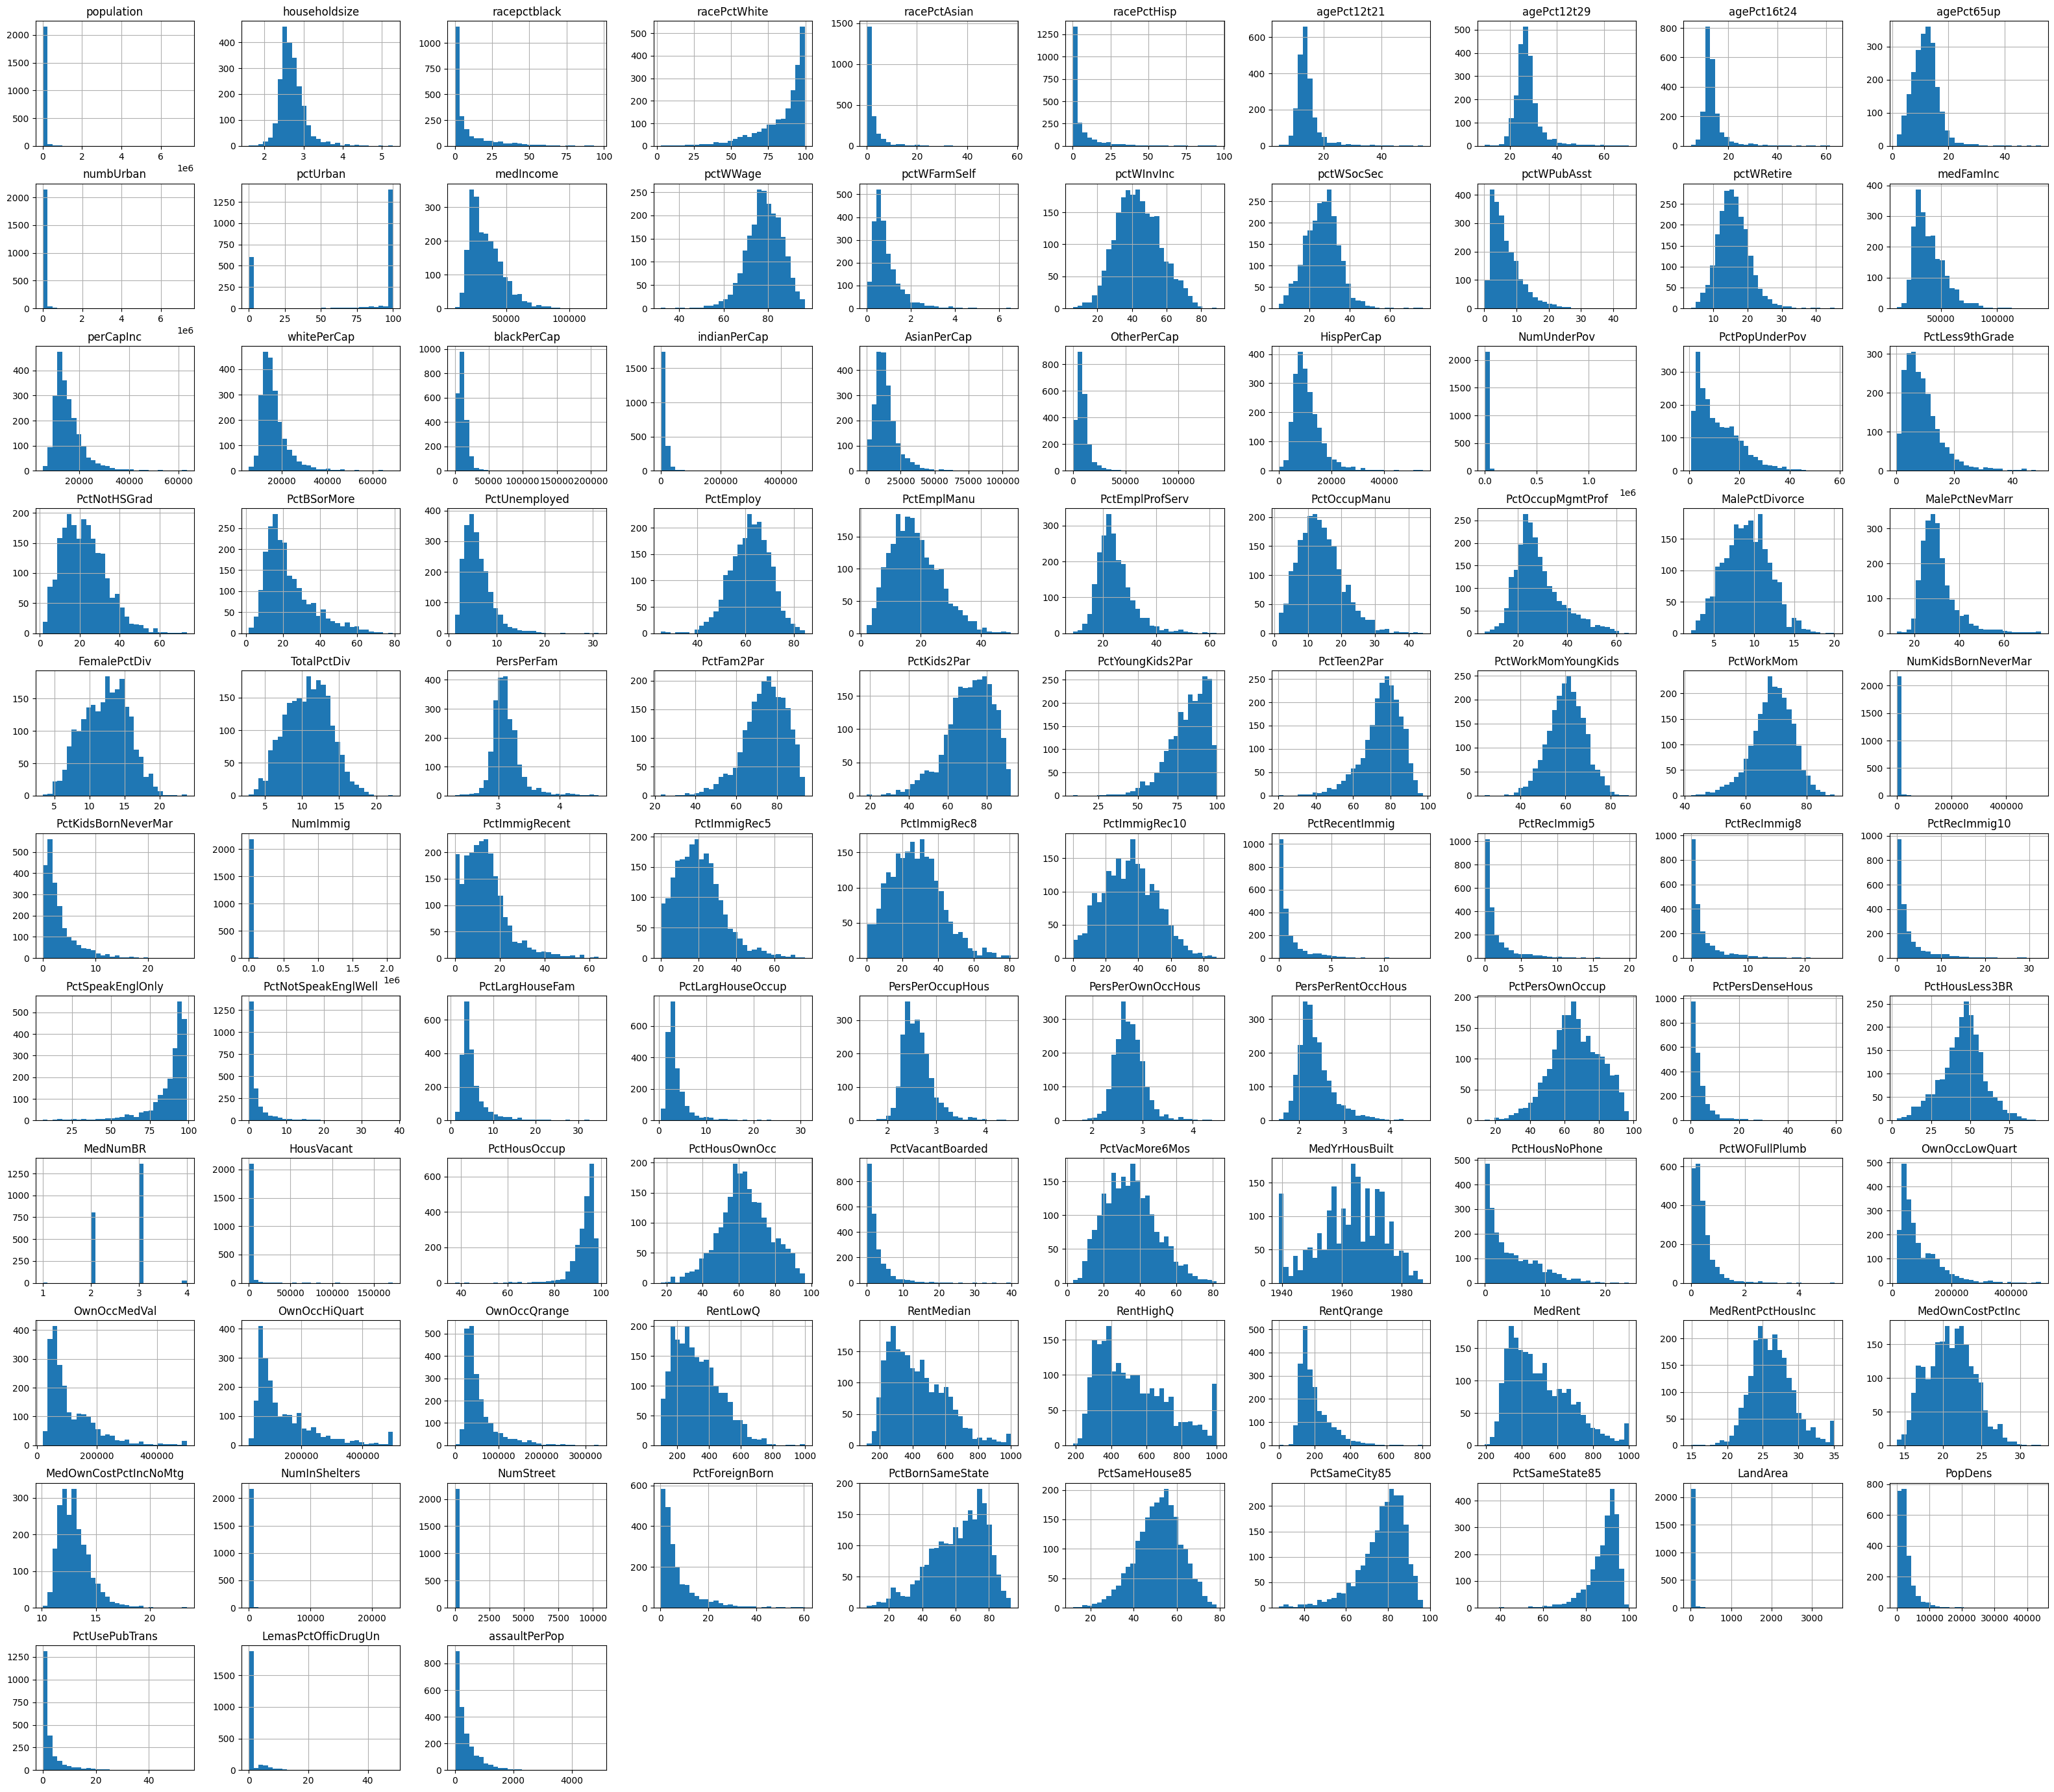

In [151]:
# Plot the histogram
df_cleaned.hist(bins=30, figsize=(40, 35))
plt.show()

As can be seen from the above historgrams, a lot of the features are skewed. Hence, a min-max scaler is chosen to normalize the data since it can be used on data that does not follow a normal distribution. A min-max scaler changes the data into a range of 0 to 1. This is done to ensure that the features are on the same scale and to prevent features with larger values from dominating the model.

In [152]:
# Create a min-max scaler
scaler = MinMaxScaler()

# Fit and transform the data
df_normalized = scaler.fit_transform(df_cleaned)

# Filter Methods

## Obtaining the Correlation Matrix

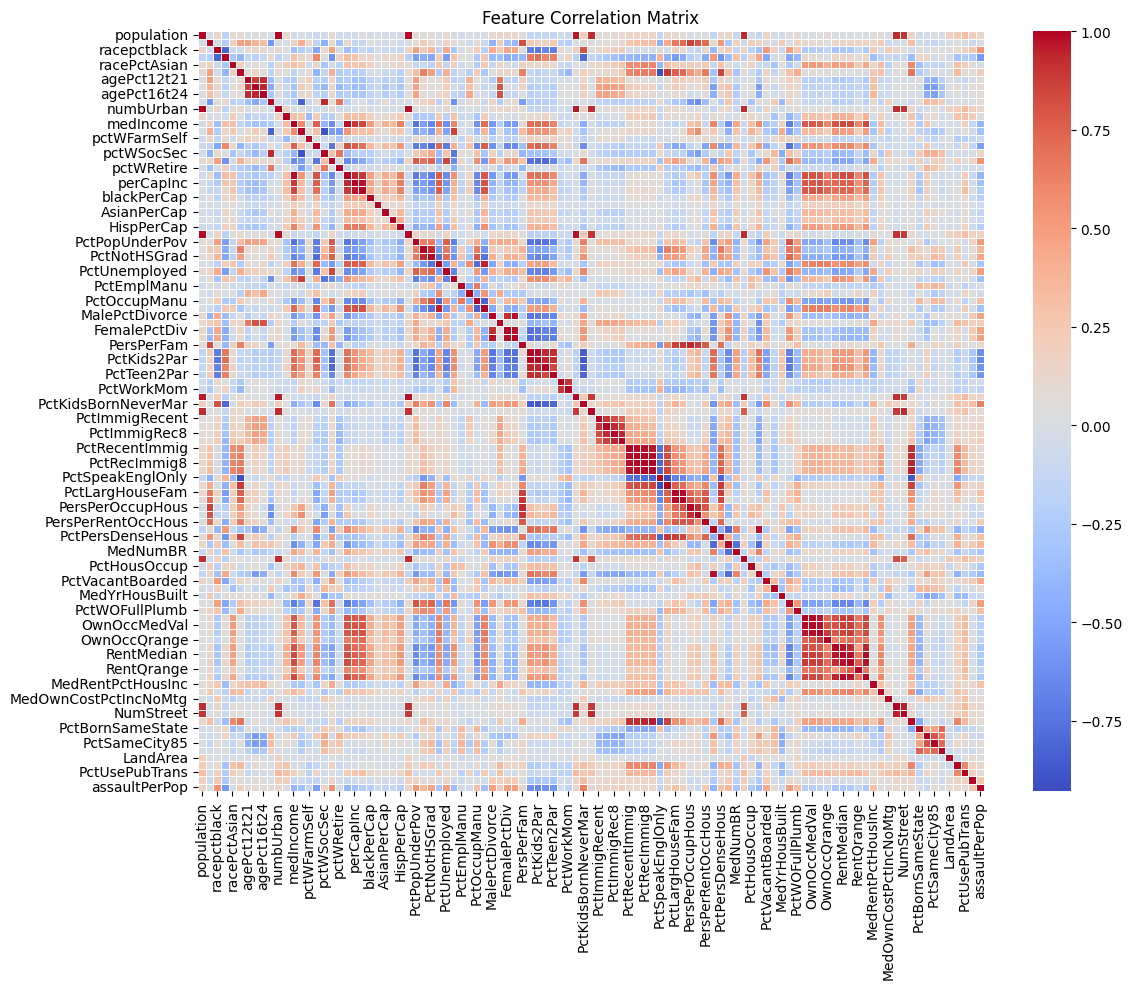

In [153]:
# Convert df_normalized back to DataFrame
df_normalized_df = pd.DataFrame(df_normalized, columns=df_cleaned.columns)

# Create correlation matrix
correlation_matrix = df_normalized_df.corr()

# Create heatmap using seaborn
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## Selecting a Threshold

The threshold selected was 0.7. This threshold was chosen to ensure to highly correlated feature pairs are removed as to avoid multicollinearity and only keep highly correlated features with the target variable.

In [154]:
# Set correlation threshold
CORRELATION_THRESHOLD = 0.7  # High correlation threshold

# Find highly correlated feature pairs
highly_correlated = np.where(np.abs(correlation_matrix) > CORRELATION_THRESHOLD)
highly_correlated = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.iloc[x, y]) 
                    for x, y in zip(*highly_correlated) if x != y and x < y]  # Remove self-correlations and duplicates

# Keep one feature from each highly correlated pair
features_to_drop = set()
for feat1, feat2, corr in highly_correlated:
    # Keep the feature that has higher correlation with target (assaultPerPop)
    corr1 = abs(correlation_matrix.loc[feat1, 'assaultPerPop'])
    corr2 = abs(correlation_matrix.loc[feat2, 'assaultPerPop'])
    if corr1 < corr2:
        features_to_drop.add(feat1)
    else:
        features_to_drop.add(feat2)

# Convert df_normalized back to DataFrame
df_normalized_df = pd.DataFrame(df_normalized, columns=df_cleaned.columns)

# Drop highly correlated features
df_normalized_uncorrelated = df_normalized_df.drop(columns=features_to_drop)

## Splitting the Dataset

The dataset is split in a 80:20 ratio for training and testing respectively. This ratio is chosen as to ensure that the model has sufficient data for training while also having enough data to test the model and get a reliable estimate of the model's performance.

In [155]:
from sklearn.model_selection import train_test_split

# Split features and target
X = df_normalized_uncorrelated.drop('assaultPerPop', axis=1)
y = df_normalized_uncorrelated['assaultPerPop']

# Split data with 80-20 ratio and fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=46
)

## Training a Neural Network

Mean Squared Error: 0.0049166739


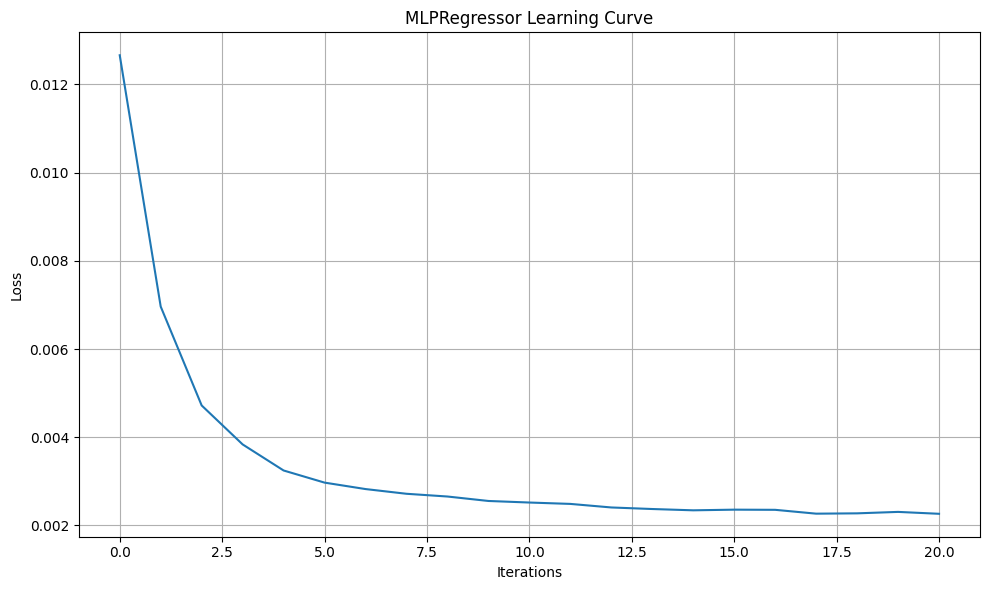

In [156]:
# Initialize the MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=46)

# Train the model
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Compute the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.10f}")

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(mlp.loss_curve_)
plt.title('MLPRegressor Learning Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

## Wrapper Methods

## Sequential Forward Selection (SFS) & Sequential Backward Selection (SBS)

### Sequential Forward Selection (SFS)

In [ ]:
def evaluate_feature_subset(X_train, X_test, y_train, y_test, feature_indices):
    """
    Evaluate a subset of features using MLPRegressor
    """
    # Select only the features we want to evaluate
    X_train_subset = X_train[:, feature_indices]
    X_test_subset = X_test[:, feature_indices]
    
    # Initialize and train the model
    mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=46)
    mlp.fit(X_train_subset, y_train)
    
    # Make predictions and calculate MSE
    y_pred = mlp.predict(X_test_subset)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

def sequential_forward_selection(X_train, X_test, y_train, y_test, max_features=40):
    """
    Perform Sequential Forward Selection with termination when no improvement is found
    
    Parameters:
    -----------
    X_train, X_test : numpy arrays of shape (n_samples, n_features)
        Training and test feature matrices
    y_train, y_test : numpy arrays of shape (n_samples,)
        Training and test target vectors
    max_features : int
        Maximum number of features to select
        
    Returns:
    --------
    selected_features : list
        Indices of selected features
    performance_history : list
        MSE scores for each iteration
    """
    n_features = X_train.shape[1]
    selected_features = []
    performance_history = []
    remaining_features = list(range(n_features))
    
    # Get baseline performance with no features
    current_best_mse = float('inf')
    
    while len(selected_features) < max_features and remaining_features:
        best_mse = float('inf')
        best_feature = None
        improvement_found = False
        
        # Try adding each remaining feature
        for feature in remaining_features:
            # Create new feature subset with current feature added
            current_features = selected_features + [feature]
            
            # Evaluate this feature subset
            mse = evaluate_feature_subset(X_train, X_test, y_train, y_test, current_features)
            
            # Update best feature if this performed better
            if mse < best_mse:
                best_mse = mse
                best_feature = feature
        
        # Check if we found an improvement over current best MSE
        if best_mse < current_best_mse:
            improvement_found = True
            current_best_mse = best_mse
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            performance_history.append(best_mse)
        else:
            break
            
    return selected_features, performance_history

### Sequential Backward Selection (SBS)

In [158]:
def evaluate_feature_subset(X_train, X_test, y_train, y_test, feature_indices):
    """

    Evaluate a subset of features using MLPRegressor

    """
    
    X_train_subset = X_train[:, feature_indices]
    X_test_subset = X_test[:, feature_indices]
    
    mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=46)
    mlp.fit(X_train_subset, y_train)
    
    y_pred = mlp.predict(X_test_subset)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

def sequential_backward_selection(X_train, X_test, y_train, y_test):
    """
    Perform Sequential Backward Selection with proper termination condition
    """
    n_features = X_train.shape[1]
    selected_features = list(range(n_features))  # Start with all features
    performance_history = []
    
    # Get initial performance with all features
    current_mse = evaluate_feature_subset(X_train, X_test, y_train, y_test, selected_features)
    performance_history.append(current_mse)
    
    searching = True
    while searching and len(selected_features) > 1:  # Keep at least one feature
        best_mse = float('inf')
        worst_feature = None
        searching = False  # Will be set to True if we find an improvement
        
        # Try removing each remaining feature
        for feature_to_remove in selected_features:
            # Create new feature subset without current feature
            current_features = [f for f in selected_features if f != feature_to_remove]
            
            # Evaluate this feature subset
            mse = evaluate_feature_subset(X_train, X_test, y_train, y_test, current_features)
            
            # Update best feature to remove if this performed better or equal
            if mse <= best_mse:
                best_mse = mse
                worst_feature = feature_to_remove
        
        # Check if removing the worst feature improves or matches current performance
        if best_mse <= current_mse:
            searching = True  # Continue searching since we found an improvement
            current_mse = best_mse
            selected_features.remove(worst_feature)
            performance_history.append(best_mse)
            
    return selected_features, performance_history

## Strengths & Limitations of SFS & SBS

Both Sequential Forward Selection (SFS) and Sequential Backward Selection (SBS) result in lower MSE values compared to the baseline model.

Sequential Forward Selection (SFS) improved the MSE while selecting only 4 features, which indicates that the dataset contained a lot of redundant features. While reducing features helped improve the MSE and lower computational costs, removing so many of the features could have led to a loss of information.

Sequential Backward Selection (SBS) resulted in the lowest MSE. However, it only removed two features from the dataset and hence it did not improve the computational costs significantly.

Lastly, since both SFS and SBS are greedy algorithms, they do not guarantee the optimal solution as they only focus on finding the local optimal solution instead of the global optimal solution.

## Training a Neural Network with SFS & SBS

### Training a Neural Network with SFS

In [ ]:
# Run the Sequential Forward Selection
selected_features, performance_history = sequential_forward_selection(
    X_train.values, X_test.values, y_train.values, y_test.values
)

# Create final dataset with selected features
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

# Train final model with selected features
final_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=46)
final_model.fit(X_train_selected, y_train)
final_predictions = final_model.predict(X_test_selected)
final_mse = mean_squared_error(y_test, final_predictions)

print(f"\nFinal model MSE with {len(selected_features)} selected features: {final_mse:.6f}")


Final model MSE with 4 selected features: 0.004427


### Training a Neural Network with SBS

In [160]:
# Run the Sequential Backward Selection
selected_features, performance_history = sequential_backward_selection(
    X_train.values, X_test.values, y_train.values, y_test.values
)

# Create final dataset with selected features
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

# Train final model with selected features
final_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=46)
final_model.fit(X_train_selected, y_train)
final_predictions = final_model.predict(X_test_selected)
final_mse = mean_squared_error(y_test, final_predictions)

print(f"\nFinal model MSE with {len(selected_features)} retained features: {final_mse:.6f}")


Final model MSE with 28 retained features: 0.004270


# Feature projection

## Principal Component Analysis(PCA)

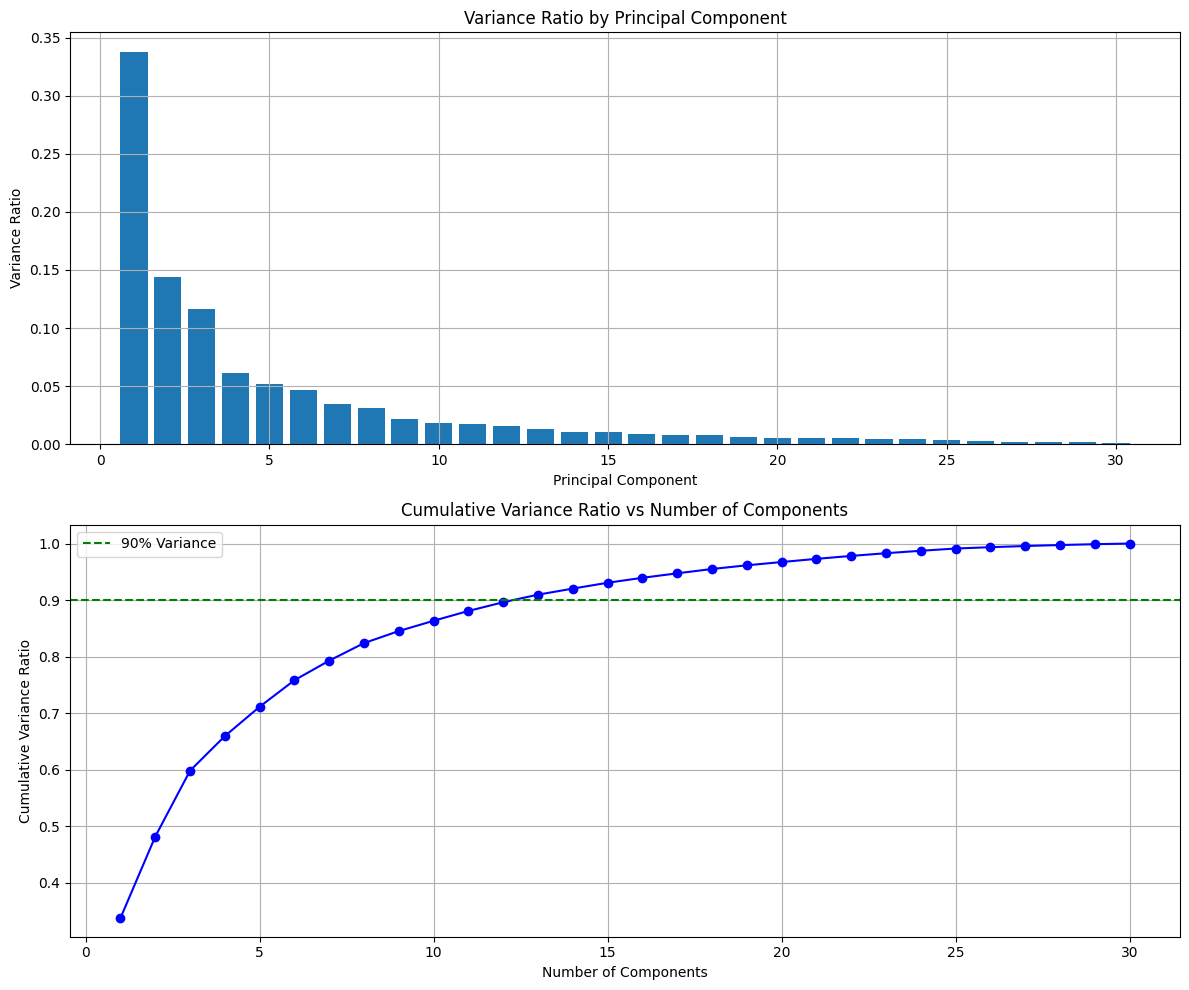

Components needed for 80.0% variance: 8
Components needed for 90.0% variance: 13
Components needed for 95.0% variance: 18


In [ ]:
def analyze_pca(X):
    """
    Perform PCA and visualize variance ratios
    """
    # Initialize PCA without limiting components
    pca = PCA()
    
    # Fit PCA
    pca_result = pca.fit_transform(X)
    
    # Calculate cumulative variance ratio
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Individual variance ratios
    ax1.bar(range(1, len(pca.explained_variance_ratio_) + 1), 
            pca.explained_variance_ratio_)
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Variance Ratio')
    ax1.set_title('Variance Ratio by Principal Component')
    ax1.grid(True)
    
    # Plot 2: Cumulative variance ratio
    ax2.plot(range(1, len(cumulative_variance_ratio) + 1), 
             cumulative_variance_ratio, 
             'bo-')
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Cumulative Variance Ratio')
    ax2.set_title('Cumulative Variance Ratio vs Number of Components')
    ax2.grid(True)
    ax2.axhline(y=0.90, color='g', linestyle='--', label='90% Variance')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Find number of components for different variance thresholds
    for threshold in [0.80, 0.90, 0.95]:
        n_components = np.argmax(cumulative_variance_ratio >= threshold) + 1
        print(f"Components needed for {threshold*100}% variance: {n_components}")
    
    return pca, pca_result, cumulative_variance_ratio

# Prepare the data
X = df_normalized_uncorrelated.drop('assaultPerPop', axis=1)

# Run PCA analysis
pca, pca_result, cumulative_variance = analyze_pca(X)

## Selecting Cut-off for PCA

In [162]:
N_COMPONENTS = 13

# Initialize PCA with selected number of components
pca = PCA(n_components=N_COMPONENTS)

# Get features (X) and target (y)
X = df_normalized_uncorrelated.drop('assaultPerPop', axis=1)
y = df_normalized_uncorrelated['assaultPerPop']

# Fit and transform the data
X_pca = pca.fit_transform(X)

# Convert to DataFrame for easier handling
X_pca_df = pd.DataFrame(
    X_pca,
    columns=[f'PC{i+1}' for i in range(N_COMPONENTS)]
)

## How Cut-off Point is Selected

The cut-off point was selected to be 13 because it reduces the number of features while also capturing 90% of the variance in the data. This ensures that there is enough information so that our model can make accurate predictions while also reducing the number of features to prevent overfitting and lower computational costs.

## Training a Neural Network with PCA

In [163]:
# Split data using same ratio (80-20) and random state as Task 2
X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca,
    y,
    test_size=0.2,
    random_state=46
)

# Initialize MLPRegressor with same parameters as Task 2
mlp_pca = MLPRegressor(
    hidden_layer_sizes=(100,),
    max_iter=1000,
    random_state=46
)

# Train the model
mlp_pca.fit(X_train_pca, y_train)

# Make predictions on test set
y_pred_pca = mlp_pca.predict(X_test_pca)

# Calculate MSE
mse_pca = mean_squared_error(y_test, y_pred_pca)
print(f"Final MSE: {mse_pca:6f}")


Final MSE: 0.004238


# Comparison

## Comparing MSE of filter, SFS, SBS and PCA

The worst MSE was achieved by the filter method. This may be because the filter method kept features that were redundant as it only removed features that were highly correlated with each other. Additionally, it did not consider the interactions of features. 

The second worst MSE was achieved by SFS. This may be because SFS removed too many features and hence led to a loss of information. Moreover, SFS is a greedy algorithm and hence it is possible that it chose a solution that was not optimal because it only focused on finding the local optimal solution.

The second best MSE was achieved by SBS. This may be because SBS only removed two features and hence did not lead to a loss of information but helped to slightly lower dimensionality.

The best MSE was achieved by PCA. This may be because PCA lowered dimensionality while also not reducing the information.

## Methods with the Best Results

The methods with the best results were SBS and PCA. 

PCA had the best overall result. PCA was able to reduce the dimensionality by almost half which would help reduce redunant features and overfitting. However, since it kept 90% variance of data variance it was able to retain enough information to make accurate predictions. It also likely was able to work so well because the relationship between the variables is linear.

SBS had the second best overall result. While SBS only reduced the dimensionality by only two features, the fact that SBS starts with all the features being included allowed it to consider interactions between features which helped it retain more predictive information and hence achieve a lower MSE. 